# Setup

## Imports & Settings

In [5]:
%load_ext autoreload
%autoreload 2

import os
import re
import itertools
import functools
import scipy
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
# sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Panel & Column Names (from Metadata & To Be Created)
panel = "TUQ97N"
# panel = "XR4UZH"
suffix = ""  # no file suffix for object h5ad file (main object)
sub_dir = None
# suffix = "_mucosa"  # e.g., for region; also may need to change `sub_dir`
# sub_dir = "regions/mucosa"  # subdirectory to read from & write outputs to
capitalize_sample = True if panel == "TUQ97N" else False
# suffix = "_new"  # suffix for object h5ad file (to avoid overwrite)

# Samples/Runs
run = None  # just look for samples in all Xenium runs for the panel
# run = "CHO-001"  # run all from this run; so don't have to specify samples
samples = "all"  # use samples = "all" with run = something for all from run
# or run = None for all available samples
# samples = ["50006B"]
genes = {
    "CD Risk": ["LACC1", "LRRK2", "PTGER4"],
    "SnC Marker": ["CDKN2A", "CDKN1A", "TP53", "PLAUR"],
    "Apoptosis-Resistance": ["BCL2"],
    "SASP": ["IL4", "IL13", "IL1A", "CXCL8", "CCL2", "CEBPB", "NFKB1",
             "TGFB1", "IGFBP7"],
    "SASP-IL6": ["OSM", "IL6", "IL6ST"],
    "Fibrosis": ["SUCNR1", "CXCR4", "IL33", "IL23A",
                 "IL1B", "IL12", "IL17", "IL36", "TL1A", "IL11", "IFNG",
                 "IL22", "IL10", "IL21", "IL34", "CCL11"],
    "ER Stress/UPR": ["ATF4"],
    "Autophagy": ["MTOR", "ATG3", "ATG5", "ATG7", "ATG12", "ATG16L1", "SQSTM1",
                  "BECN1", "IRGM1", "ATG8", "ATG6"],
    "DNA Repair": ["ERCC1", "ERCC4"],
    "Healing": ["LCN2", "MMP9", "GREM1", "PDGFRA"],
    "Mixed": ["ICAM1"]
}   # genes of interest: can just specify list of genes
genes_dict_colors = [
    "#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
    "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"
] if isinstance(genes, dict) else None  # colors for each "key" of genes dict

# Main Directories
usr_write_rel_path = f"{os.getlogin()}/data/shared-xenium-library"
d_hpc = "/mnt/cho_lab" if os.path.exists(
    "/mnt/cho_lab") else "/sc/arion/projects/untreatedIBD"  # HPC path
d_nfs = os.path.join(d_hpc, "bbdata2") if os.path.exists(os.path.join(
    d_hpc, "bbdata2")) else os.path.join(
        d_hpc, "chobiolab-core/shared-xenium-library")
d_usr = os.path.join(d_hpc, "disk2", usr_write_rel_path) if os.path.exists(
    os.path.join(d_hpc, "disk2")) else os.path.join(d_hpc, usr_write_rel_path)
d_obj = d_usr  # CHANGE IF WRITING & PULLING OBJECTS FROM DIFFERENT PATHS
d_img = os.path.join(d_hpc, f"cache/tissue-registry/xenium/{panel}") if (
    "arion" in d_hpc) else os.path.join(d_hpc, f"bbdata1/xenium/{panel}")

# Construct Directories (Less Likely to Need Changes)
# Mirror my file/directory tree in the `d_usr` directory
obj_ext = ".h5ad"  # extension for processed objects
out_subdir_markers = "find_markers"  # sub-directory under out_dir for markers
out_obj = os.path.join(d_obj, f"outputs/{panel}/nebraska")
out_dir = os.path.join(d_usr, f"outputs/{panel}/nebraska")  # to save objects
out_plot = None if out_dir is None else os.path.join(
    out_dir, "plots")  # plot output directory
if sub_dir is not None:  # add sub-directory name if needed
    d_obj, out_dir, out_plot = [os.path.join(x, sub_dir) if x else None
                                    for x in [d_obj, out_dir, out_plot]]
file_mdf = os.path.join(d_usr, f"samples_{panel}.csv")  # metadata file path
file_a = None  # don't map manual annotations
file_a = os.path.join(out_dir, "annotation_dictionaries/annotations_all.xlsx")
print(f"\n\n\n{'=' * 80}\nDirectories\n{'=' * 80}\n\nHPC Entry Point (Cho): "
      f"{d_hpc}\nData: {d_nfs}\nMetadata: {file_mdf}\nImages: {d_img}\n"
      f"Object/Outputs:\n\t{out_dir} (objects)\n\t{out_plot} (plots)\n\t"
      f"{os.path.join(out_dir, out_subdir_markers)} (markers)\n"
      f"Annotations: {file_a}\n\n\n")

# Leiden Column & Manual Annotation Mapping Options
col_leiden = f"leiden_res1pt5_dist0_npc30"
col_assignment = "bucket"  # column in annotation file whose labels to use
col_cluster = col_leiden if file_a is None else col_assignment
# col_assignment = "annotation"  # more specific cell types
suffix_ct = f"_{col_leiden}" + str(f"_{col_cluster}" if (
    col_cluster != col_leiden) else "")  # new out file suffix ~ cell type

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Directories

HPC Entry Point (Cho): /mnt/cho_lab
Data: /mnt/cho_lab/bbdata2
Metadata: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_TUQ97N.csv
Images: /mnt/cho_lab/bbdata1/xenium/TUQ97N
Object/Outputs:
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska (objects)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/plots (plots)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/find_markers (markers)
Annotations: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/annotations_all.xlsx





## Setup

Get constants (e.g., column names in metadata), read metadata, create dictionary of clustering parameters (so can iterate across different clustering specifications to make multiple versions, e.g., at multiple resolutions) using `res_list`, `min_dist_list`, and `n_comps_list`, make any output directories (e.g., for processed objects, plots, find markers results, Xenium Explorer cluster files) if any don't exist yet, load data into objects, etc.

In [2]:
# Get/Set Constants
constants_dict = cr.get_panel_constants(panel_id=panel)
col_sample_id_o, col_sample_id, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]

# Read Metadata
metadata = cr.pp.get_metadata_cho(
    d_nfs, file_mdf, panel_id=panel, samples=samples, run=run,
    capitalize_sample=capitalize_sample)  # get metadata
print("\n\n", metadata[list(set([
    col_sample_id_o, col_subject, col_condition, col_inflamed, col_stricture,
    col_segment]).intersection(metadata))])

# Annotation File
f_ann = pd.read_excel(file_a, index_col=[0, 1]).dropna(how="all").dropna(
    how="all", axis=1)
f_ann = f_ann.reset_index().astype({f_ann.index.names[1]: "int"}).astype({
    f_ann.index.names[1]: "string"}).set_index(f_ann.index.names)

# Final Setup
if out_plot is not None:
    os.makedirs(out_plot, exist_ok=True)  # ensure plot save path exists
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cluster)



                    sample_id inflammation  subject_id   Condition stricture
Sample                                                                     
Uninflamed-50403A2   50403A2   uninflamed       50403  uninflamed        no
Uninflamed-50403A1   50403A1   uninflamed       50403  uninflamed        no
Uninflamed-50336C     50336C   uninflamed       50336  uninflamed        no
Inflamed-50336B       50336B     inflamed       50336    inflamed        no
Stricture-50336A      50336A     inflamed       50336   stricture       yes
Stricture-50403C2    50403C2     inflamed       50403   stricture       yes
Stricture-50403C1    50403C1     inflamed       50403   stricture       yes
Inflamed-50403B       50403B     inflamed       50403    inflamed        no
Stricture-50217C      50217C     inflamed       50217   stricture       yes
Uninflamed-50217B     50217B   uninflamed       50217  uninflamed        no
Inflamed-50217A       50217A     inflamed       50217    inflamed        no
Stricture

# Map Manual Annotations

# Analyze

The first clustering version (first specified in `res_list`) is the cell type column used by default in downstream analyses (because it was specified in `kws_init["col_cell_type"]` when creating the object and thus is stored in `self._columns["col_cell_type"]`). Specify `col_cell_type` as an argument in the following functions to use a different column.



Uninflamed-50403A2




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-011/output-XETG00189__0010589__50403A2-TUQ97N-EA__20240513__201050
         /cell_feature_matrix.h5                                                                                   




Counts: Initial


	Observations: 212695

	Genes: 469







 AnnData object with n_obs × n_vars = 212695 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                                           
ABCA7         ENSG00000064687  Gene Expression  Unknown
ACTA2         ENSG00000107796  Gene Expression  Unknown
ACTG2         ENSG00000163017  Gene Expression  Unknown
ADAM15        ENSG00000143537  Gene Expression  Unknown
ADAM28        ENSG00000042980  Gene Expression  Unknown 

 



col_gene_symbols="gene_symbols"
col_cell_type="bucket"
col_sample_id="Sample"
col_b

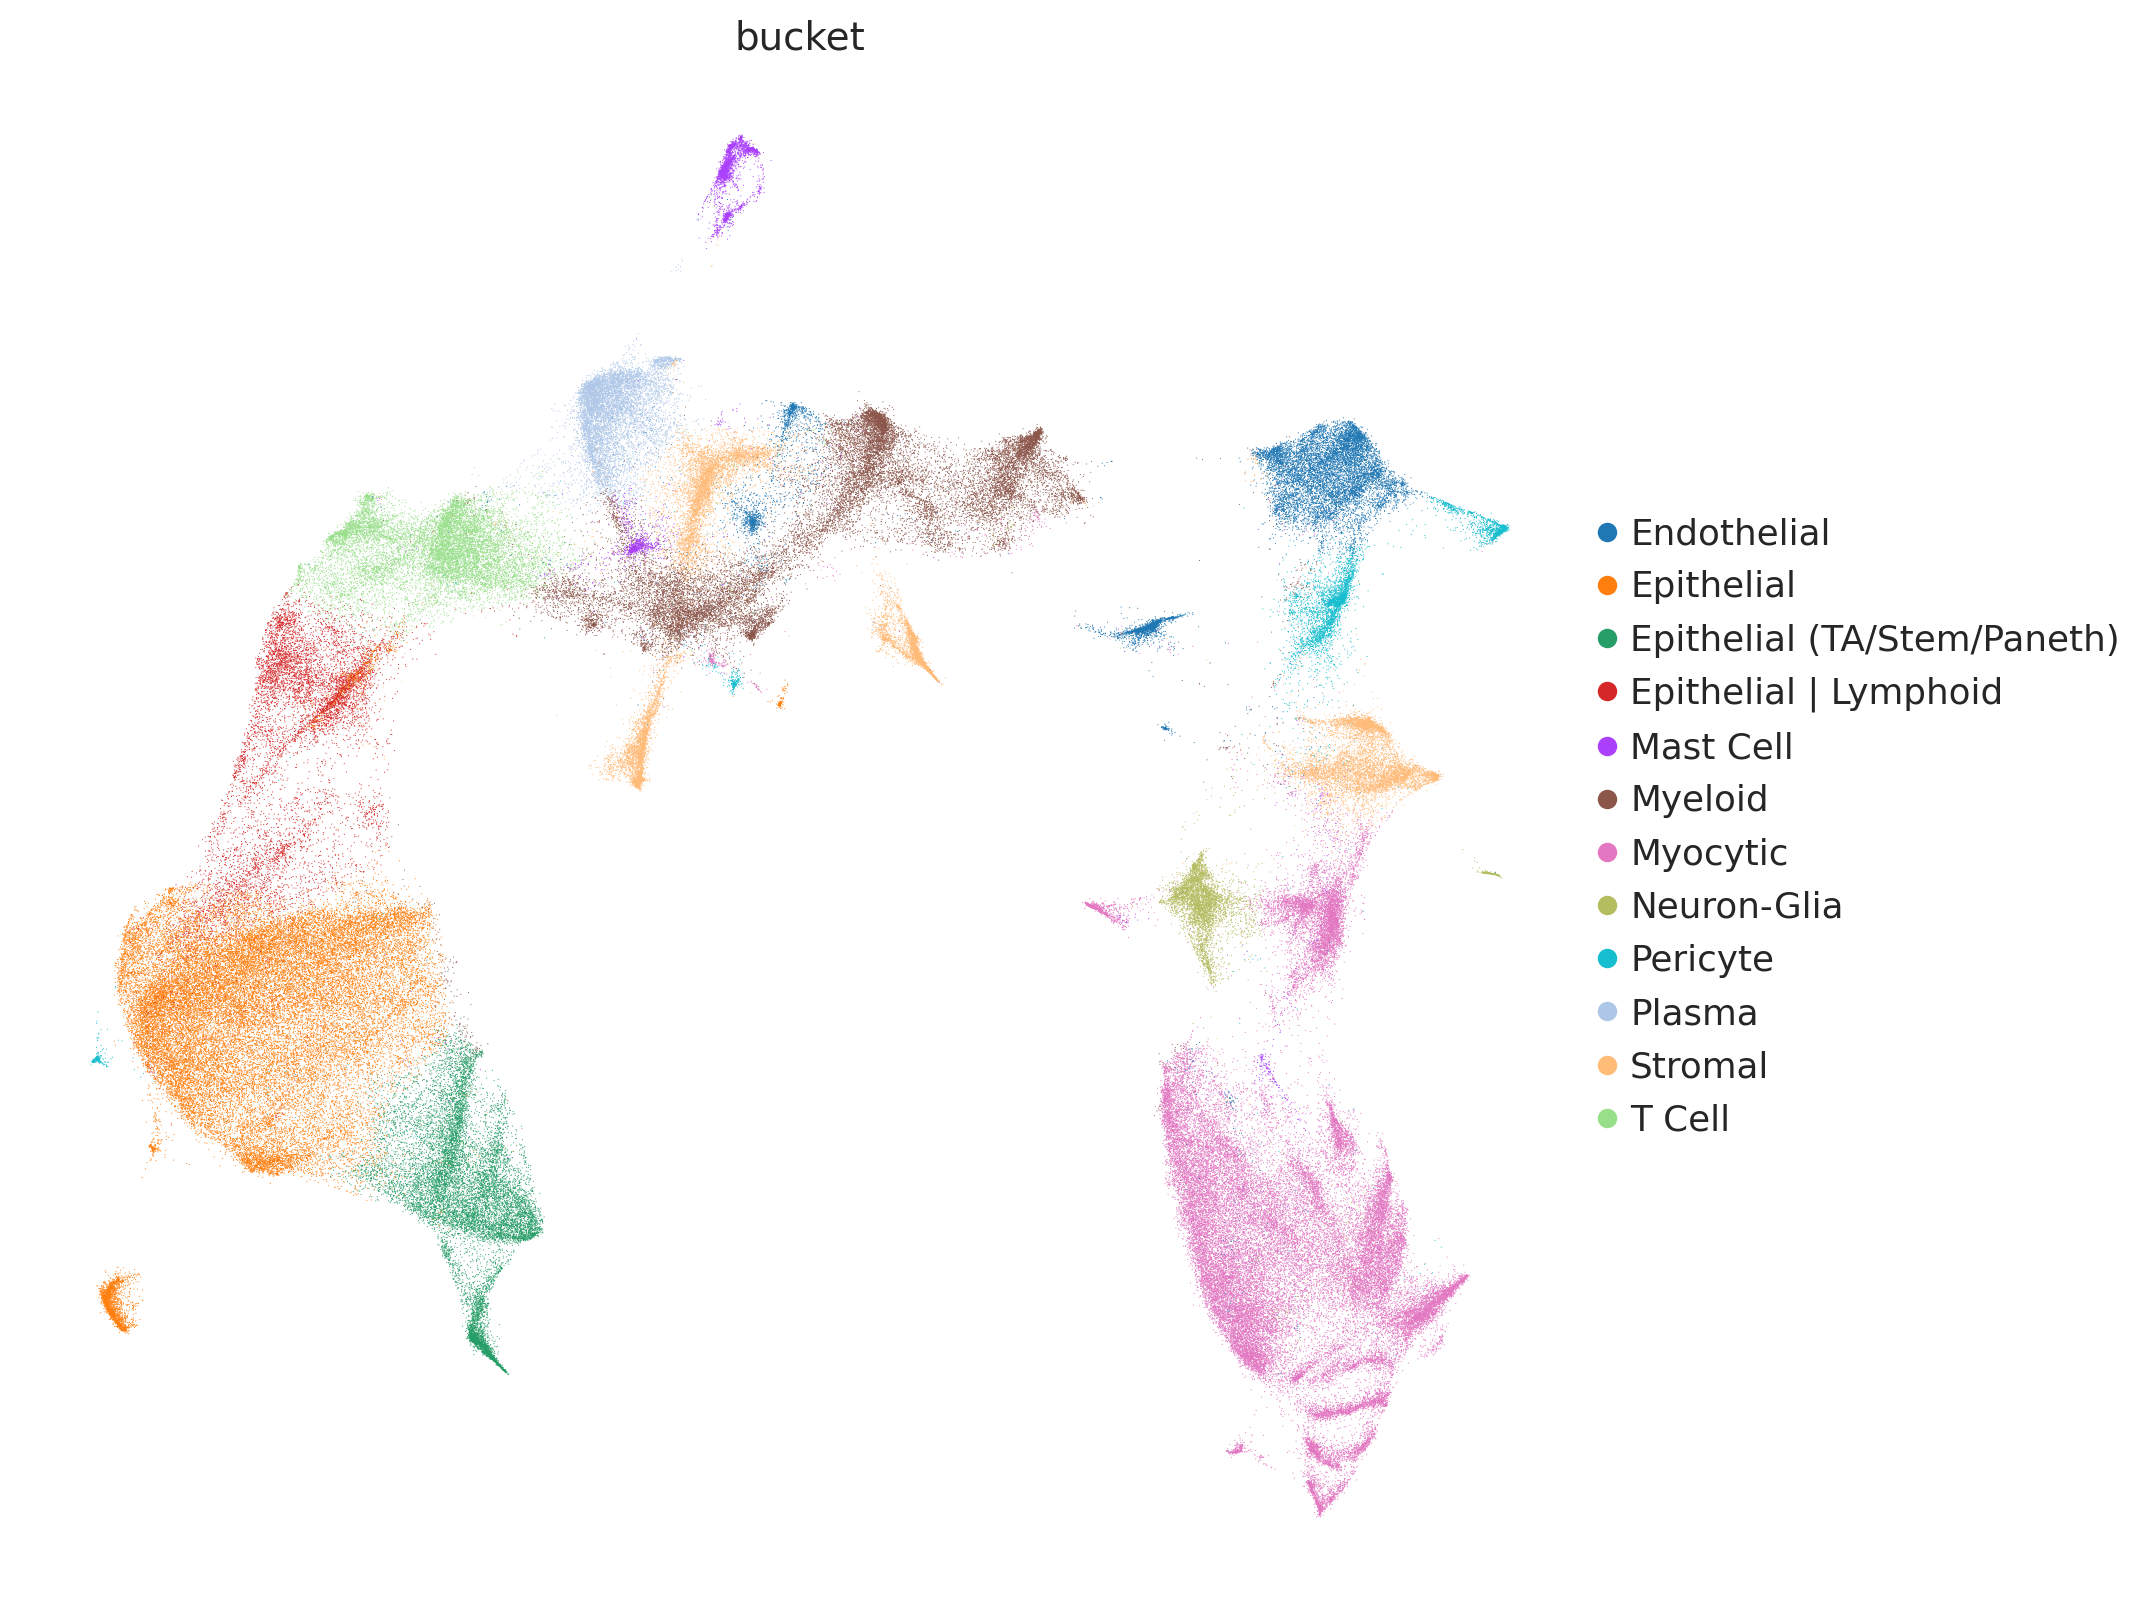

In [7]:
# Set Up Plot Dictionaries
fig_central, fig_neigh, fig_cooccur, fig_svg = {}, {}, {}, {}
fig_gex = {"spatial": {}, "heat": {}, "dot": {}}

# Iterate Samples
for x in metadata.index.values:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")

    # Load Data
    out = os.path.join(out_obj, x + suffix + obj_ext)  # object output path
    if not os.path.exists(out):
        print(f"Skipping {x}: {out} doesn't exist!")

    self = cr.Spatial(metadata.loc[x][col_f], library_id=x, **kws_init)
    self.update_from_h5ad(out)  # update with prior preprocessing
    for j in metadata.dropna(how="all", axis=1):  # add metadata to .obs
        self.rna.obs.loc[:, j] = str(metadata.loc[x][j])
    self.rna.obs.loc[:, col_object] = out  # path for processed object

    # Map Manual Annotations
    annot = f_ann.loc[f"{self._library_id}___{col_leiden}_dictionary.xlsx"]
    _ = self.annotate_clusters(
        annot[col_assignment], col_cell_type=col_leiden,
        col_annotation=col_cluster)

    # Gene Expression Plots (Only GEX Data)
    goi = list(set(pd.unique(functools.reduce(lambda u, v: u + v, [
        genes[g] for g in genes])) if isinstance(genes, dict) else genes
                   ).intersection(self.rna.var_names))  # gene list
    fig_gex["spatial"][self._library_id] = self.plot_spatial(
        color=goi + [col_cluster], title=f"{self._library_id}{suffix}")
    fig_gex["dot"][self._library_id] = cr.pl.plot_dot(
        self.rna, "Annotation", genes, title=f"{self._library_id}{suffix}",
        genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
        percent="right", center=None)
    fig_gex["heat"][self._library_id] = cr.pl.plot_matrix(
        self.rna, "Annotation", genes, title=f"{self._library_id}{suffix}",
        genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
        percent="right", center=None)

    # Spatial Analyses
    _, fig_central[self._library_id] = self.calculate_centrality(
        figsize=(20, 10))
    _, fig_neigh[self._library_id] = self.calculate_neighborhood(
        figsize=(60, 30))
    _, fig_cooccur[self._library_id] = self.find_cooccurrence(
        figsize=(60, 20), kws_plot=dict(wspace=3))
    _, fig_svg[self._library_id] = self.find_svgs(
        genes=goi, method="moran", n_perms=10, kws_plot=dict(
            legend_fontsize="large"), figsize=(15, 15))

    # Write Plots
    if out_plot is not None:
        for v, u in zip(["central", "neighbor", "cooccur", "svg"], [
                fig_central, fig_neigh, fig_cooccur, fig_svg]):
            u[self._library_id].savefig(
                out_plot, f"{v}_{self._library_id}{suffix}{suffix_ct}.jpeg")
        for p in fig_gex:
            fig_gex[p][self._library_id].savefig(
                out_plot, f"gex_{p}_{self._library_id}{suffix}"
                f"{suffix_ct}_{'_'.join(goi)}.jpeg")